This code is developed by "Fatemehzahed kachaee" based on "Hamiltonian Neural Networks by
Sam Greydanus, Misko Dzamba,  Jason Yosinski" https://greydanus.github.io/2019/05/15/hamiltonian-nns/ and "Hamiltonian Neural Networks Ayush Garg Sammed Shantinath Kagi" https://github.com/ayushgarg31/HNN-Neurips2019

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import autograd
import pandas as pd
np.random.seed(0)

In [14]:
def grad_Hamiltonian(t,r):
    k,m=1,1
    q, p = r 
    tfq = tf.Variable(q, dtype='float64')
    tfp = tf.Variable(p, dtype='float64')

    with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
        tape0.watch(tfq)
        tape1.watch(tfp)

        h1 = 1-tf.math.cos(tfq)
        h2 = tfp**2
        dHdq=tape0.gradient(h1, tfq)
        dHdp=tape1.gradient(h2, tfp)
        S = np.array([dHdp, -dHdq])
    return S
        
        
def trajectory(t,y0):
    noise_std=0.1
    sol=integrate.solve_ivp(grad_Hamiltonian,(0,10),y0=y0,t_eval=np.linspace(0,10,100))
    #sol = integrate.solve_ivp(fun=grad_Hamiltonian,t_span=t,y0=y0)
    q_new,p_new=sol.y
    
    dydt = [grad_Hamiltonian( None,y) for y in sol['y'].T]
    dydt = np.stack(dydt).T
    dq, dp = np.split(dydt,2)
    # add noise
    p_new = sol.y[1] + (np.random.uniform(0,0.4,100))
    q_new = sol.y[0] + (np.random.uniform(0,0.4,100))
    return q_new,p_new,dq,dp

In [15]:
def get_dataset(seed=0, samples=50, test_split=0.2):    # inja 50ta nemune random az file data bardashte be surste zoje moratab p&q va dp&dq neveshte va 20 darsad oona ro dade test ghara dade
    data = {'meta': locals()}
    t=[0,10]
    y0=np.asarray([1.0,0.0])
    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        q, p, dq, dp= trajectory(t,y0)
        xs.append( np.stack( [q, p]).T )
        dxs.append( np.stack( [dq, dp]).T )
        
    data['q&p'] = np.concatenate(xs)
    data['dq&dp'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['q&p']) * test_split)
    split_data = {}
    for k in ['q&p', 'dq&dp']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [16]:
data = get_dataset()
x_train = tf.constant(data['q&p'], dtype=tf.double)
x_test = tf.constant( data['test_q&p'], dtype=tf.double)
y_train = tf.constant(data['dq&dp'], dtype=tf.double)
y_test = tf.constant(data['test_dq&dp'], dtype=tf.double)

In [17]:
# This part of the code is taken directly from "Hamiltonian Neural Networks Ayush Garg Sammed Shantinath Kagi"
# https://github.com/ayushgarg31/HNN-Neurips2019
class HNN(keras.Model):
    def __init__(self, input_dim=2, hidden_dim=200):
        super(HNN, self).__init__()
        self.d1 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.d2 = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self.d3 = tf.keras.layers.Dense(1)
        M = np.eye(input_dim)
        M = np.concatenate((M[input_dim//2:], -M[:input_dim//2]), axis=0)
        self.M = tf.constant(M, dtype='double')

    def call(self, x):
        y = self.d1(x)
        y = self.d2(y)
        y = self.d3(y)
        return y

    def forward(self, x):
        with tf.GradientTape() as tape:
            y = self.d1(x)
            y = self.d2(y)
            y = self.d3(y)
        y = tape.gradient(y, x)
        y = y @ self.M
        return y

In [18]:
def train_HNN(data, learning_rate = 1e-3, epochs = 200):
    model = HNN(input_dim=x_train.shape[1], hidden_dim=200)
    loss_object = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for i in range(epochs):
        with tf.GradientTape() as tape1:
            tape1.watch(model.trainable_variables)
            predictions = model.forward(tf.Variable(tf.stack(x_train)))
            loss = loss_object(tf.Variable(tf.stack(y_train)), predictions)
        gradients = tape1.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        #print (i, loss)
    return model

In [19]:
hnn_model = train_HNN(data, epochs=200, learning_rate=1e-3);

In [20]:
def integrate_model_HNN(model, t_span, y0, **kwargs):
    def fun(t, np_x):
        np_x = tf.Variable(tf.reshape(np_x, (1,2)), dtype='double')
        dx = model.forward(np_x)
        return dx
    return integrate.solve_ivp(fun=fun, t_span=t_span, y0=y0, **kwargs)

In [21]:
def integrate_models(x0=np.asarray([1, 0]), t_span=None, t_eval=None, noise_std=0.1):
    kwargs = {'t_eval': t_eval, 'rtol': 1e-12}
    true_path = integrate.solve_ivp(fun=dynamics_fn, t_span=t_span, y0=x0, **kwargs)
    true_x = true_path['y'].T
    hnn_ivp = integrate_model_HNN(hnn_model, t_span, x0, **kwargs)
    hnn_x = hnn_ivp['y'].T
    
    return true_x 

def energy_loss(true_x, integrated_x):
    true_energy = (true_x**2).sum(1)
    integration_energy = (integrated_x**2).sum(1)
    return np.mean((true_energy - integration_energy)**2)

In [22]:
t_span = [0,30]
y0 = np.array([1.0, 0])
kwargs = {'t_eval': np.linspace(t_span[0], t_span[1], 300), 'rtol': 1e-12}
hnn_ivp = integrate_model_HNN(hnn_model, t_span, y0, **kwargs)

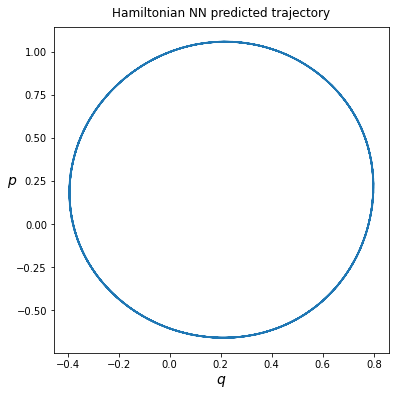

In [23]:
q,p=hnn_ivp.y
fig = plt.figure(figsize=(6, 6), facecolor='white')

fig.add_subplot(1, 1, 1, frameon=True)
plt.plot(p,q)  
plt.xlabel("$q$", fontsize=14)
plt.ylabel("$p$", rotation=0, fontsize=14)
plt.title("Hamiltonian NN predicted trajectory", pad=10);

Text(0, 0.5, '$H$')

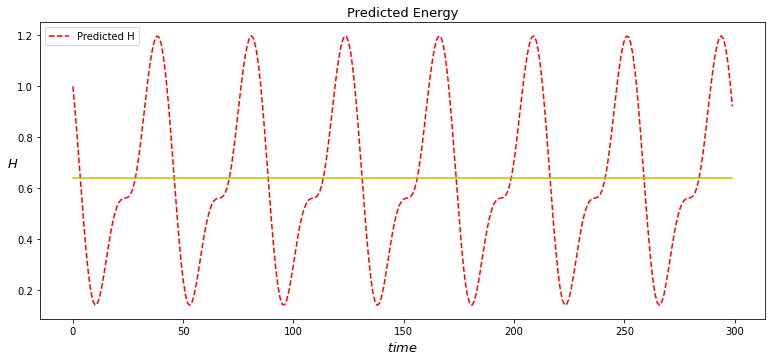

In [24]:
Hp=q**2+p**2
pmeanE=np.mean(Hp)*np.ones(len(p))
plt.figure(figsize=(13,12))

plt.subplot(212)
plt.plot(Hp,'r--')
plt.plot(pmeanE,'y')
plt.title('Predicted Energy', fontsize=13)
plt.legend(['Predicted H'])
plt.xlabel('$time$', fontsize=13)
plt.ylabel('$H$',rotation=0, fontsize=13)